In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# suppress warning
import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import scipy
from sklearn.metrics import r2_score
import pmdarima as pm

In [3]:
fileName = 'C:/Users/mcarp/OneDrive/Documents/Monthly NYC Accident Data - Master Sheet.csv'
months = pd.read_csv(fileName)
dfmonthly = pd.DataFrame(months)

In [4]:
largeFile='C:/Users/mcarp/Downloads/Motor_Vehicle_Collisions_-_Crashes.csv'
large_file = pd.read_csv(largeFile)
dfCrash = pd.DataFrame(large_file)

In [5]:
lastFile='C:/Users/mcarp/OneDrive/Documents/Collision Monthly Borough.csv'
_file = pd.read_csv(lastFile)
dfBoroughs = pd.DataFrame(_file)

In [6]:
dfBoroughs['Injuries']=dfBoroughs['MotoristsInjured']+dfBoroughs['PassengersInjured']+dfBoroughs['PedestriansInjured']+dfBoroughs['CyclistsInjured']
dfBoroughs['Injuries/Population'] = dfBoroughs['Injuries']/dfBoroughs['PopEstimate(2019)']
dfBoroughs['Fatalities']=dfBoroughs['MotoristsKilled']+dfBoroughs['PassengersKilled']+dfBoroughs['PedestriansKilled']+dfBoroughs['CyclistsKilled']
dfBoroughs['Fatalities/Population'] = dfBoroughs['Fatalities']/dfBoroughs['PopEstimate(2019)']
dfBoroughs['Cyclist/Pedestrian Injuries']=dfBoroughs['CyclistsInjured']+dfBoroughs['PedestriansInjured']
dfBoroughs['Cyclist/Pedestrian Fatalities']=dfBoroughs['CyclistsKilled']+dfBoroughs['PedestriansKilled']
dfBoroughs['Date'] = dfBoroughs['Month'].astype(str)+'-'+dfBoroughs['Year'].astype(str)

In [7]:
dfStat = dfBoroughs[dfBoroughs['Borough']=='STATEN ISLAND']
dfMan = dfBoroughs[dfBoroughs['Borough']=='MANHATTAN']
dfBk = dfBoroughs[dfBoroughs['Borough']=='BROOKLYN']
dfBronx = dfBoroughs[dfBoroughs['Borough']=='BRONX']
dfQueens = dfBoroughs[dfBoroughs['Borough']=='QUEENS']

print(dfStat.shape,dfMan.shape,dfBk.shape,dfBronx.shape,dfQueens.shape)

(110, 21) (110, 21) (110, 21) (110, 21) (110, 21)


In [8]:
dfStat=dfStat.reset_index()
del dfStat['index']
dfMan=dfMan.reset_index()
del dfMan['index']
dfBk=dfBk.reset_index()
del dfBk['index']
dfBronx=dfBronx.reset_index()
del dfBronx['index']
dfQueens=dfQueens.reset_index()
del dfQueens['index']
dfQueens.head(2)

,Year,Month,Borough,PopEstimate(2019),Num_Motor_Vehicle_Collisions,Injury_or_fatal_collisions,MotoristsInjured,MotoristsKilled,PassengersInjured,PassengersKilled,...,CyclistsKilled,PedestriansInjured,PedestriansKilled,Injuries,Injuries/Population,Fatalities,Fatalities/Population,Cyclist/Pedestrian Injuries,Cyclist/Pedestrian Fatalities,Date
0,2012,1,QUEENS,2253858,4380,855,447,2,456,2,...,0,238,1,1170,0.000519,5,0.000002,267,1,1-2012
1,2012,2,QUEENS,2253858,3946,785,420,1,426,0,...,0,240,4,1111,0.000493,5,0.000002,265,4,2-2012


## Boroughs

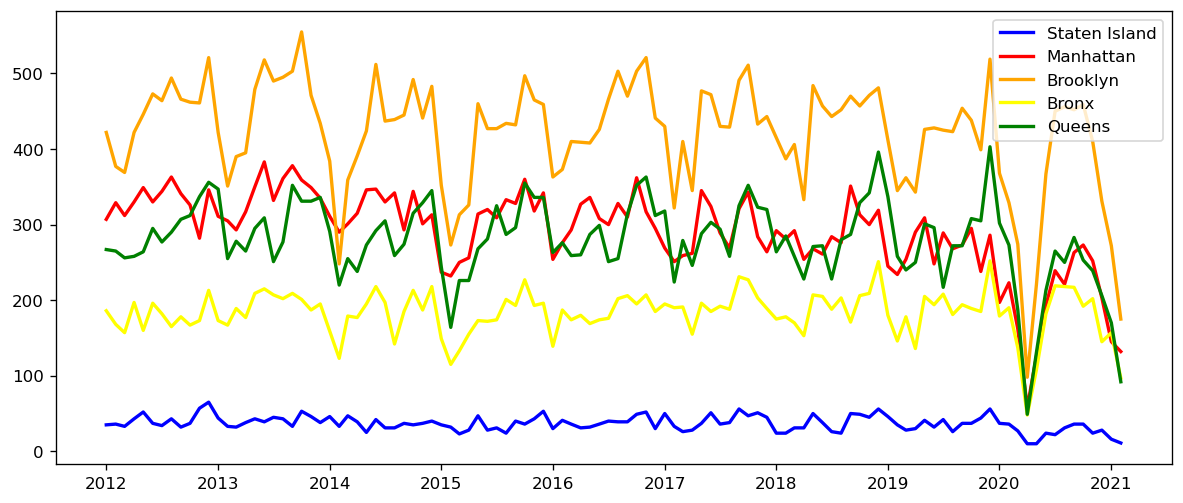

In [286]:
fig, ax = plt.subplots(figsize=(12, 5))
plt.plot(pd.to_datetime(dfStat.Date),'Cyclist/Pedestrian Injuries', data=dfStat, marker='', color='blue', linewidth=2, label="Staten Island")
plt.plot(pd.to_datetime(dfMan.Date),'Cyclist/Pedestrian Injuries', data=dfMan, marker='', color='red', linewidth=2, label="Manhattan")
plt.plot(pd.to_datetime(dfBk.Date),'Cyclist/Pedestrian Injuries', data=dfBk, marker='', color='orange', linewidth=2, label="Brooklyn")
plt.plot(pd.to_datetime(dfBronx.Date),'Cyclist/Pedestrian Injuries', data=dfBronx, marker='', color='yellow', linewidth=2, label="Bronx")
plt.plot(pd.to_datetime(dfQueens.Date),'Cyclist/Pedestrian Injuries', data=dfQueens, marker='', color='green', linewidth=2, label="Queens")
plt.legend()
plt.show()

In [287]:
dfs=[dfMan[:96],dfBronx[:96],dfBk[:96],dfQueens[:96],dfStat[:96]]
for df in dfs:
    f, PSD = scipy.signal.periodogram(df['Cyclist/Pedestrian Injuries'])
    PSD = PSD[f>0.01]
    f = f[f>0.01]
    print('Strongest period of {0} = {1}'.format(df['Borough'][1],1/f[np.argmax(PSD)]))

Strongest period of MANHATTAN = 12.0
Strongest period of BRONX = 12.0
Strongest period of BROOKLYN = 12.0
Strongest period of QUEENS = 12.0
Strongest period of STATEN ISLAND = 6.0


In [288]:
for df in dfs:
    print(df['Borough'][1],df['Cyclist/Pedestrian Injuries'][84:96].mean())

MANHATTAN 269.0833333333333
BRONX 187.33333333333334
BROOKLYN 414.5
QUEENS 288.25
STATEN ISLAND 37.833333333333336


In [289]:
print(df_monthly['Cyclist/Pedestrian Injuries'][84:96].mean())

1197.0


_________________________________________________________________________

## Bronx Model

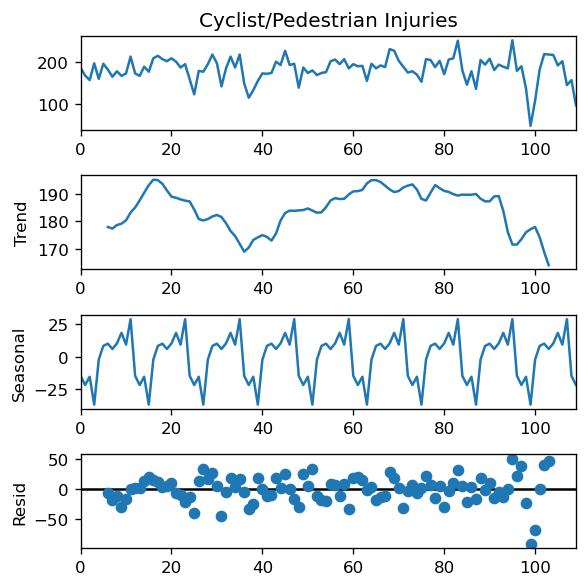

In [23]:
matplotlib.rcParams['figure.figsize'] = [5,5]
res = sm.tsa.seasonal_decompose(dfBronx['Cyclist/Pedestrian Injuries'],model='additive',freq=12)
res.plot()
plt.show()

In [24]:
result = adfuller(dfBronx['Cyclist/Pedestrian Injuries'])
print('p-value: %f' % result[1])
result = adfuller(dfBronx['Cyclist/Pedestrian Injuries'].diff().diff(12).dropna().values)
print('p-value: %f' % result[1])

p-value: 0.003927
p-value: 0.000348


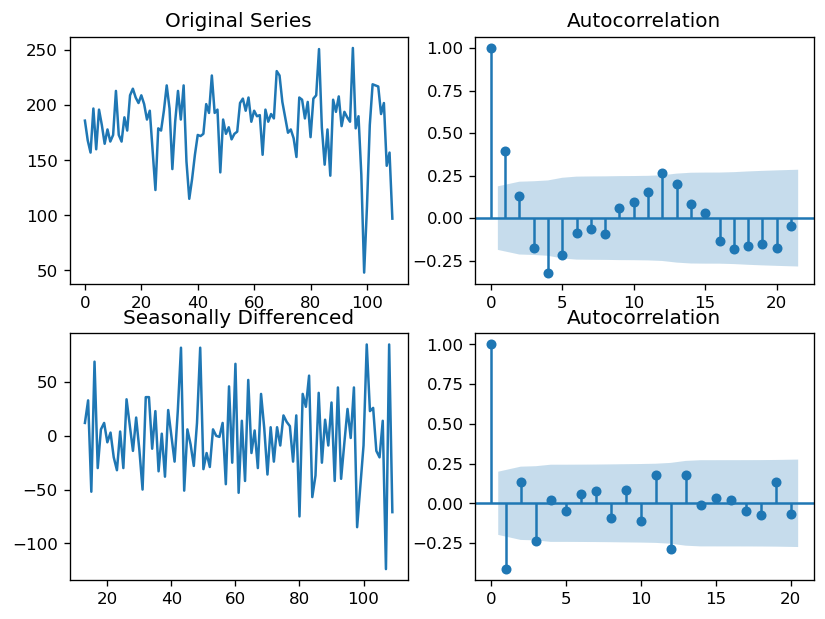

In [25]:
plt.rcParams.update({'figure.figsize':(8,6), 'figure.dpi':120})
fig, axes = plt.subplots(2, 2)

axes[0, 0].plot(dfBronx['Cyclist/Pedestrian Injuries']); axes[0, 0].set_title('Original Series')
plot_acf(dfBronx['Cyclist/Pedestrian Injuries'].dropna(), ax=axes[0, 1])

axes[1, 0].plot(dfBronx['Cyclist/Pedestrian Injuries'].diff().diff(12)); axes[1, 0].set_title('Seasonally Differenced')
plot_acf(dfBronx['Cyclist/Pedestrian Injuries'].diff().diff(12).dropna(), ax=axes[1, 1])
plt.show()

In [26]:
model = pm.auto_arima(dfBronx['Cyclist/Pedestrian Injuries'], d=1, D=1,
                      m=12, trend='c', seasonal=True, 
                      start_p=0, start_q=0, max_order=6, test='adf',
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=962.744, Time=0.29 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=984.923, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=961.364, Time=0.46 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=940.288, Time=0.55 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=954.093, Time=0.15 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=941.799, Time=0.96 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=941.544, Time=1.26 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=949.428, Time=0.41 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.24 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=960.750, Time=0.30 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.09 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=935.116, Time=0.92 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=inf, Time=0.45 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=937.020, Time=0.78 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=93

In [27]:
trainBronx=dfBronx[['Date','Cyclist/Pedestrian Injuries']][:84]
validBronx=dfBronx[['Date','Cyclist/Pedestrian Injuries']][84:96]
testBronx=dfBronx[['Date','Cyclist/Pedestrian Injuries']][96:]
modelBronx = SARIMAX(trainBronx['Cyclist/Pedestrian Injuries'],order=(0,1,2),seasonal_order=(0,1,1,12))
resultsBronx = modelBronx.fit()
resultsBronx.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:          Cyclist/Pedestrian Injuries   No. Observations:                   84
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -326.693
Date:                              Mon, 26 Apr 2021   AIC                            661.386
Time:                                      10:52:05   BIC                            670.436
Sample:                                           0   HQIC                           664.985
                                               - 84                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7354      0.148     -4.962      0.000      -1.026      -0.445
ma.L2         -0.1866      0.148     -1.265      0.206      -0.476       0.103
ma.S.L12      -0.8715      0.393     -2.220      0.026      -1.641      -0.102
sigma2       452.5551    206.426      2.192      0.028      47.968     857.142
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.65
Prob(Q):                              0.87   Prob(JB):                         0.72
Heteroskedasticity (H):               1.09   Skew:                             0.13
Prob(H) (two-sided):                  0.84   Kurtosis:                         2.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

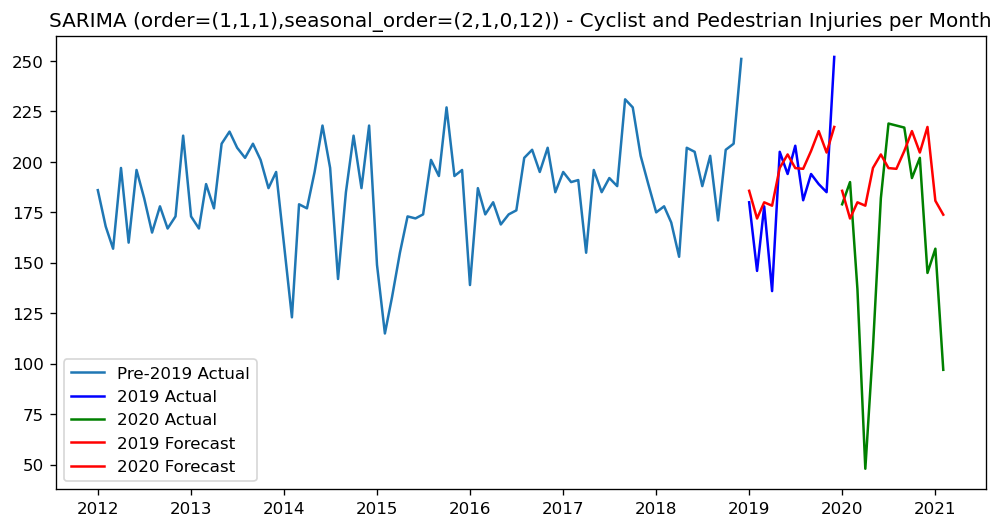

In [28]:
plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(pd.to_datetime(trainBronx.Date), trainBronx['Cyclist/Pedestrian Injuries'],label='Pre-2019 Actual')
plt.plot(pd.to_datetime(validBronx.Date), validBronx['Cyclist/Pedestrian Injuries'],color='blue',label='2019 Actual')
plt.plot(pd.to_datetime(testBronx.Date), testBronx['Cyclist/Pedestrian Injuries'],color='green',label='2020 Actual')
plt.plot(pd.to_datetime(validBronx.Date), resultsBronx.forecast(steps=len(validBronx), alpha=0.05), label='2019 Forecast', color='red')
plt.plot(pd.to_datetime(testBronx.Date), resultsBronx.forecast(steps=len(testBronx), alpha=0.05), label='2020 Forecast', color='red')
plt.title('SARIMA (order=(1,1,1),seasonal_order=(2,1,0,12)) - Cyclist and Pedestrian Injuries per Month')
plt.legend(loc='lower left')

In [29]:
r2_score(validBronx['Cyclist/Pedestrian Injuries'], resultsBronx.forecast(steps=len(validBronx), alpha=0.05))

0.4308186292060484

In [45]:
r2_score(testBronx['Cyclist/Pedestrian Injuries'], resultsBronx.forecast(steps=len(testBronx), alpha=0.05))

-0.1888174141761625

In [170]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [174]:
mean_absolute_percentage_error(validBronx['Cyclist/Pedestrian Injuries'],resultsBronx.forecast(steps=len(validBronx)))

10.010770312910209

In [175]:
mean_absolute_percentage_error(testBronx['Cyclist/Pedestrian Injuries'],resultsBronx.forecast(steps=len(testBronx)))

42.37945290401253

## Bronx Model 2019 R^2 = 0.43

## 2020 R^2 = -0.19

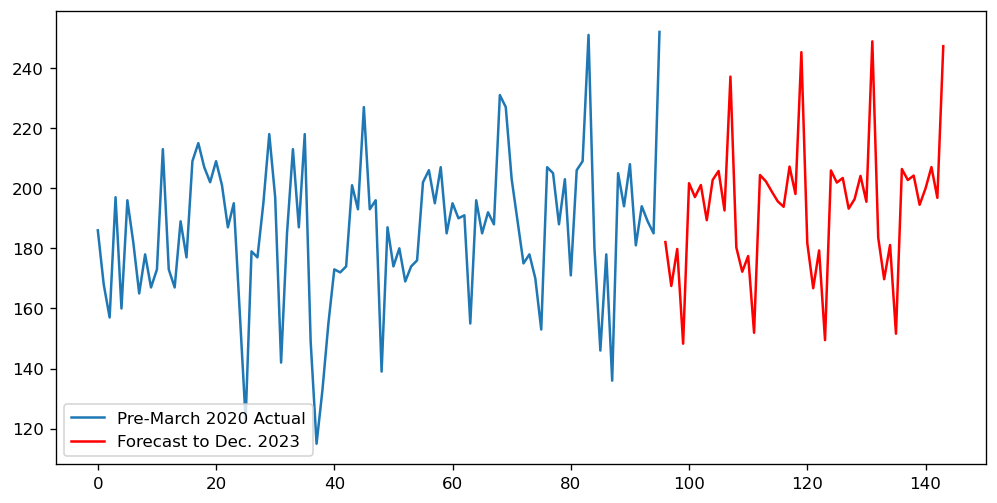

In [129]:
modelBronx2 = SARIMAX(dfBronx['Cyclist/Pedestrian Injuries'][:96],order=(1,1,2),seasonal_order=(2,1,0,12))
resultsBronx2 = modelBronx2.fit()

plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(dfBronx.index[:96], dfBronx['Cyclist/Pedestrian Injuries'][:96],label='Pre-March 2020 Actual')
plt.plot(x[96:], resultsBronx2.forecast(steps=48, alpha=0.05), label='Forecast to Dec. 2023', color='red')
plt.legend(loc='lower left')

In [251]:
res=resultsBronx2.forecast(60)
res[48:].mean()

196.89560466353933

___________________________________________________________________________________________________________________________

## Staten Island Model

Period of 6 months (as opposed to 12 in other boroughs)

In [88]:
result = adfuller(dfStat['Cyclist/Pedestrian Injuries'])
print('p-value: %f' % result[1])
result = adfuller(dfStat['Cyclist/Pedestrian Injuries'].diff().diff(6).dropna().values)
print('p-value: %f' % result[1])

p-value: 0.000000
p-value: 0.000000


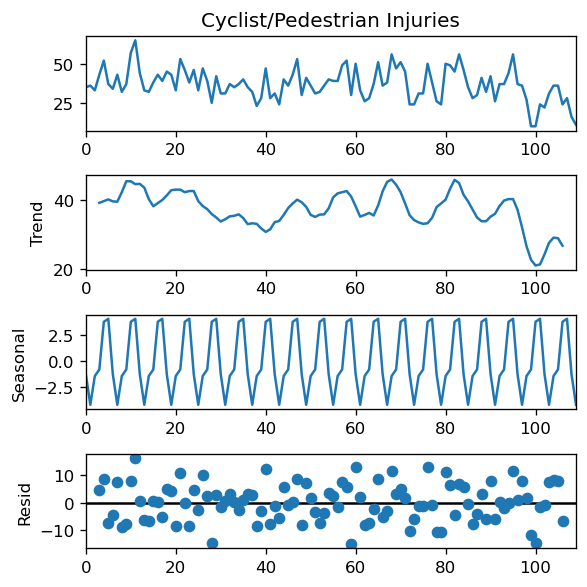

In [89]:
matplotlib.rcParams['figure.figsize'] = [5,5]
res = sm.tsa.seasonal_decompose(dfStat['Cyclist/Pedestrian Injuries'],model='additive',freq=6)
res.plot()
plt.show()

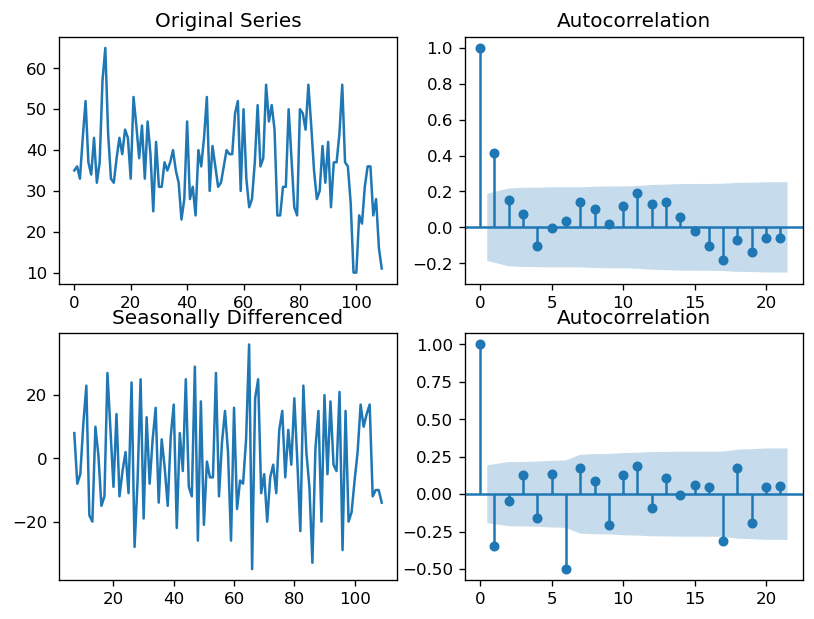

In [90]:
plt.rcParams.update({'figure.figsize':(8,6), 'figure.dpi':120})
fig, axes = plt.subplots(2, 2)

axes[0, 0].plot(dfStat['Cyclist/Pedestrian Injuries']); axes[0, 0].set_title('Original Series')
plot_acf(dfStat['Cyclist/Pedestrian Injuries'].dropna(), ax=axes[0, 1])

axes[1, 0].plot(dfStat['Cyclist/Pedestrian Injuries'].diff().diff(6)); axes[1, 0].set_title('Seasonally Differenced')
plot_acf(dfStat['Cyclist/Pedestrian Injuries'].diff().diff(6).dropna(), ax=axes[1, 1])
plt.show()

In [91]:
model = pm.auto_arima(dfStat['Cyclist/Pedestrian Injuries'], d=1, D=1,
                      m=6, trend='c', seasonal=True, 
                      start_p=0, start_q=0, max_order=12, test='adf',
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[6]             : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=864.505, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=821.372, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=inf, Time=0.62 sec
 ARIMA(1,1,0)(0,1,0)[6]             : AIC=853.516, Time=0.12 sec
 ARIMA(1,1,0)(2,1,0)[6]             : AIC=808.570, Time=0.33 sec
 ARIMA(1,1,0)(2,1,1)[6]             : AIC=inf, Time=0.58 sec
 ARIMA(1,1,0)(1,1,1)[6]             : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(2,1,0)[6]             : AIC=813.675, Time=0.26 sec
 ARIMA(2,1,0)(2,1,0)[6]             : AIC=802.947, Time=0.51 sec
 ARIMA(2,1,0)(1,1,0)[6]             : AIC=811.846, Time=0.32 sec
 ARIMA(2,1,0)(2,1,1)[6]             : AIC=inf, Time=1.11 sec
 ARIMA(2,1,0)(1,1,1)[6]             : AIC=inf, Time=0.64 sec
 ARIMA(3,1,0)(2,1,0)[6]             : AIC=804.905, Time=0.56 sec
 ARIMA(2,1,1)(2,1,0)[6]             : AIC=802.681, Time=0.68 sec
 ARIMA

In [92]:
trainSt=dfStat[['Date','Cyclist/Pedestrian Injuries']][:84]
validSt=dfStat[['Date','Cyclist/Pedestrian Injuries']][84:96]
testSt=dfStat[['Date','Cyclist/Pedestrian Injuries']][96:]
modelSt = SARIMAX(trainSt['Cyclist/Pedestrian Injuries'],order=(1,1,2),seasonal_order=(2,1,0,6))
resultsSt = modelSt.fit()
resultsSt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:        Cyclist/Pedestrian Injuries   No. Observations:                   84
Model:             SARIMAX(1, 1, 2)x(2, 1, [], 6)   Log Likelihood                -283.348
Date:                            Mon, 26 Apr 2021   AIC                            578.696
Time:                                    11:14:35   BIC                            592.759
Sample:                                         0   HQIC                           584.321
                                             - 84                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5317      0.181     -2.942      0.003      -0.886      -0.178
ma.L1         -0.0743      0.124     -0.602      0.547      -0.317       0.168
ma.L2         -0.8899      0.115     -7.736      0.000      -1.115      -0.664
ar.S.L6       -0.7503      0.116     -6.448      0.000      -0.978      -0.522
ar.S.L12      -0.3891      0.135     -2.878      0.004      -0.654      -0.124
sigma2        81.0562     15.752      5.146      0.000      50.183     111.929
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.80
Prob(Q):                              0.91   Prob(JB):                         0.25
Heteroskedasticity (H):               1.22   Skew:                             0.36
Prob(H) (two-sided):                  0.61   Kurtosis:                         2.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

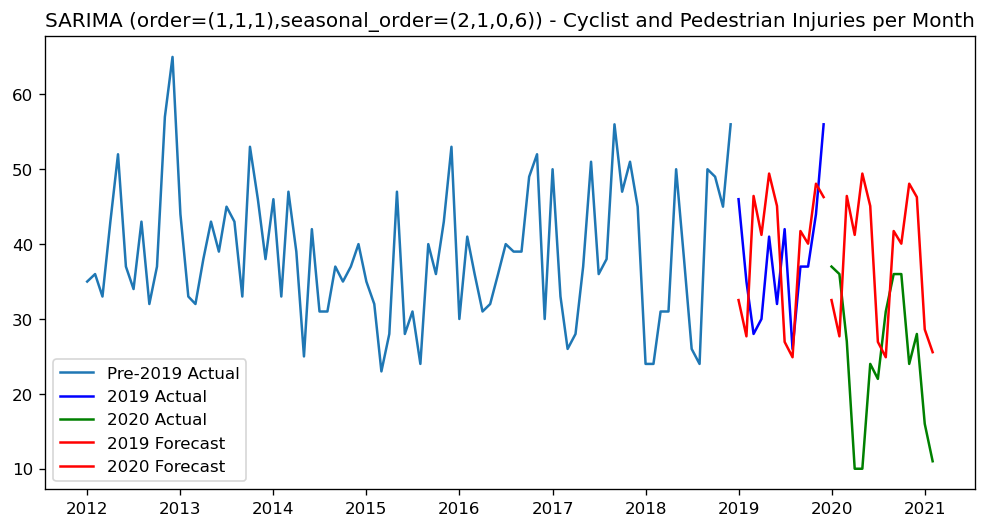

In [290]:
plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(pd.to_datetime(trainSt.Date), trainSt['Cyclist/Pedestrian Injuries'],label='Pre-2019 Actual')
plt.plot(pd.to_datetime(validSt.Date), validSt['Cyclist/Pedestrian Injuries'],color='blue',label='2019 Actual')
plt.plot(pd.to_datetime(testSt.Date), testSt['Cyclist/Pedestrian Injuries'],color='green',label='2020 Actual')
plt.plot(pd.to_datetime(validSt.Date), resultsSt.forecast(steps=len(validSt), alpha=0.05), label='2019 Forecast', color='red')
plt.plot(pd.to_datetime(testSt.Date), resultsSt.forecast(steps=len(testSt), alpha=0.05), label='2020 Forecast', color='red')
plt.title('SARIMA (order=(1,1,1),seasonal_order=(2,1,0,6)) - Cyclist and Pedestrian Injuries per Month')
plt.legend(loc='lower left')

In [291]:
r2_score(validSt['Cyclist/Pedestrian Injuries'], resultsSt.forecast(steps=len(validSt), alpha=0.05))

-0.6352262101499404

In [292]:
print('2020 R2 Score:',r2_score(testSt['Cyclist/Pedestrian Injuries'], resultsSt.forecast(steps=len(testSt), alpha=0.05)))

2020 R2 Score: -2.7387079050563763


In [293]:
mean_absolute_percentage_error(validSt['Cyclist/Pedestrian Injuries'],resultsSt.forecast(steps=len(validSt)))

25.22712857289765

In [294]:
mean_absolute_percentage_error(testSt['Cyclist/Pedestrian Injuries'],resultsSt.forecast(steps=len(testSt)))

96.26761566589715

## Staten Island Model 2019 R^2 = -0.64

## 2020 ^R2 = -2.74

In [96]:
x = np.arange(144)

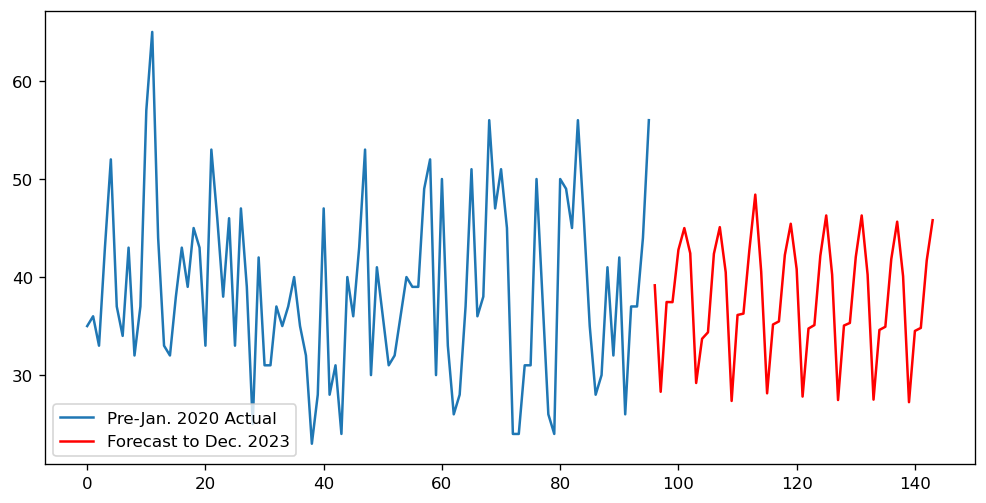

In [254]:
modelSt2 = SARIMAX(dfStat['Cyclist/Pedestrian Injuries'][:96],order=(1,1,2),seasonal_order=(2,1,0,6))
resultsSt2 = modelSt2.fit()

plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(dfStat.index[:96], dfStat['Cyclist/Pedestrian Injuries'][:96],label='Pre-Jan. 2020 Actual')
plt.plot(x[96:], resultsSt2.forecast(steps=48, alpha=0.05), label='Forecast to Dec. 2023', color='red')
plt.legend(loc='lower left')

In [255]:
res=resultsSt2.forecast(60)
res[48:].mean()

37.093468407200646

_________________________________________________________________________________________________________________

## Queens Model

In [31]:
result = adfuller(dfQueens['Cyclist/Pedestrian Injuries'])
print('p-value: %f' % result[1])
result = adfuller(dfQueens['Cyclist/Pedestrian Injuries'].diff().diff(12).dropna().values)
print('p-value: %f' % result[1])

p-value: 0.998873
p-value: 0.007564


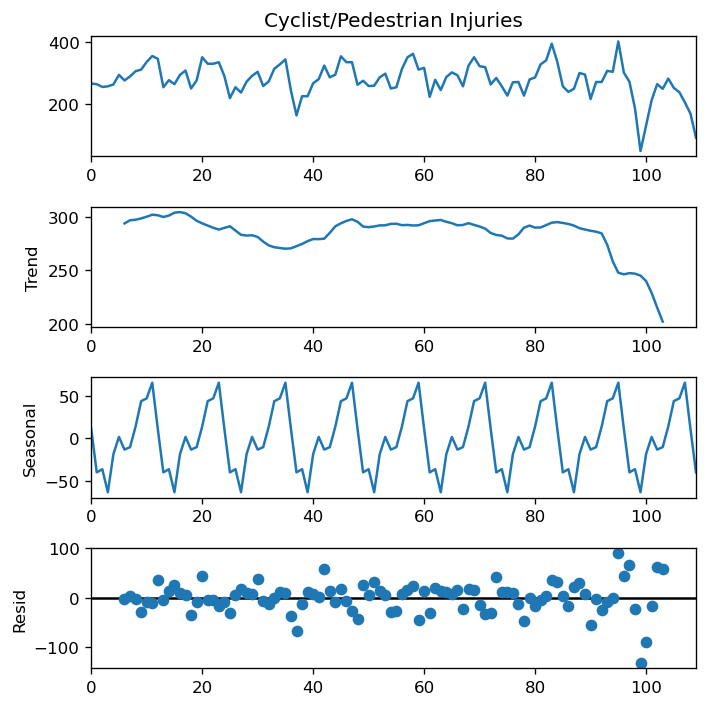

In [32]:
matplotlib.rcParams['figure.figsize'] = [6,6]
res = sm.tsa.seasonal_decompose(dfQueens['Cyclist/Pedestrian Injuries'],model='additive',freq=12)
res.plot()
plt.show()

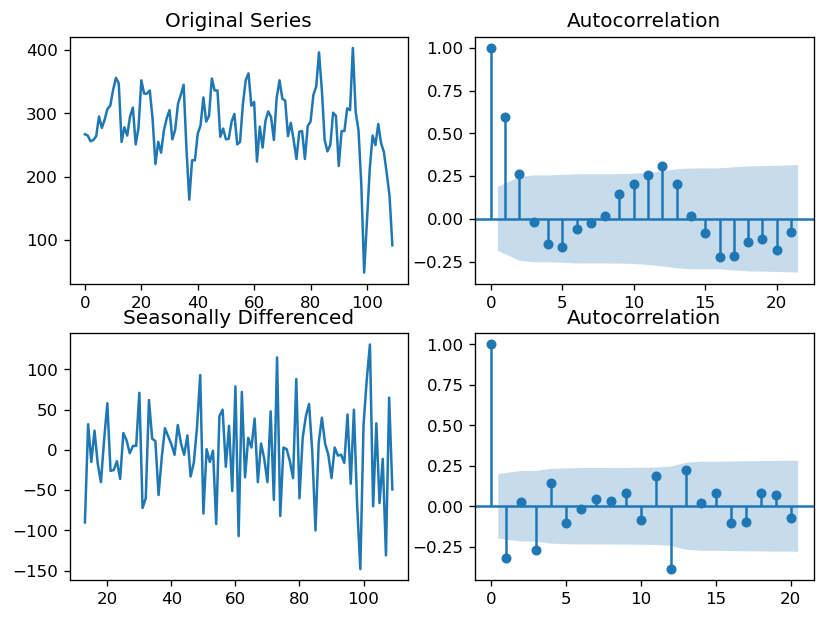

In [33]:
plt.rcParams.update({'figure.figsize':(8,6), 'figure.dpi':120})
fig, axes = plt.subplots(2, 2)

axes[0, 0].plot(dfQueens['Cyclist/Pedestrian Injuries']); axes[0, 0].set_title('Original Series')
plot_acf(dfQueens['Cyclist/Pedestrian Injuries'].dropna(), ax=axes[0, 1])

axes[1, 0].plot(dfQueens['Cyclist/Pedestrian Injuries'].diff().diff(12)); axes[1, 0].set_title('Seasonally Differenced')
plot_acf(dfQueens['Cyclist/Pedestrian Injuries'].diff().diff(12).dropna(), ax=axes[1, 1])
plt.show()

In [34]:
model = pm.auto_arima(dfQueens['Cyclist/Pedestrian Injuries'], d=1, D=1,
                      m=12, trend='c', seasonal=True, 
                      start_p=0, start_q=0, max_order=6, test='adf',
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.81 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1043.087, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1017.357, Time=0.28 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.89 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1034.480, Time=0.22 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1014.912, Time=1.07 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.06 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.44 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1018.719, Time=0.74 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1016.357, Time=0.98 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1002.857, Time=1.99 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=1005.980, Time=0.81 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=inf, Time=2.87 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=1.22 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1011.8

In [35]:
trainQn=dfQueens[['Date','Cyclist/Pedestrian Injuries']][:84]
validQn=dfQueens[['Date','Cyclist/Pedestrian Injuries']][84:96]
testQn=dfQueens[['Date','Cyclist/Pedestrian Injuries']][96:]
modelQn = SARIMAX(trainQn['Cyclist/Pedestrian Injuries'],order=(1,1,1),seasonal_order=(2,1,0,12))
resultsQn = modelQn.fit()
resultsQn.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:         Cyclist/Pedestrian Injuries   No. Observations:                   84
Model:             SARIMAX(1, 1, 1)x(2, 1, [], 12)   Log Likelihood                -346.094
Date:                             Mon, 26 Apr 2021   AIC                            702.188
Time:                                     10:53:33   BIC                            713.502
Sample:                                          0   HQIC                           706.687
                                              - 84                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1927      0.191      1.009      0.313      -0.182       0.567
ma.L1         -0.9978      1.092     -0.914      0.361      -3.138       1.142
ar.S.L12      -0.6384      0.137     -4.645      0.000      -0.908      -0.369
ar.S.L24      -0.3342      0.111     -2.999      0.003      -0.553      -0.116
sigma2       861.4715    876.380      0.983      0.326    -856.202    2579.145
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 4.25
Prob(Q):                              0.83   Prob(JB):                         0.12
Heteroskedasticity (H):               1.32   Skew:                             0.54
Prob(H) (two-sided):                  0.50   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

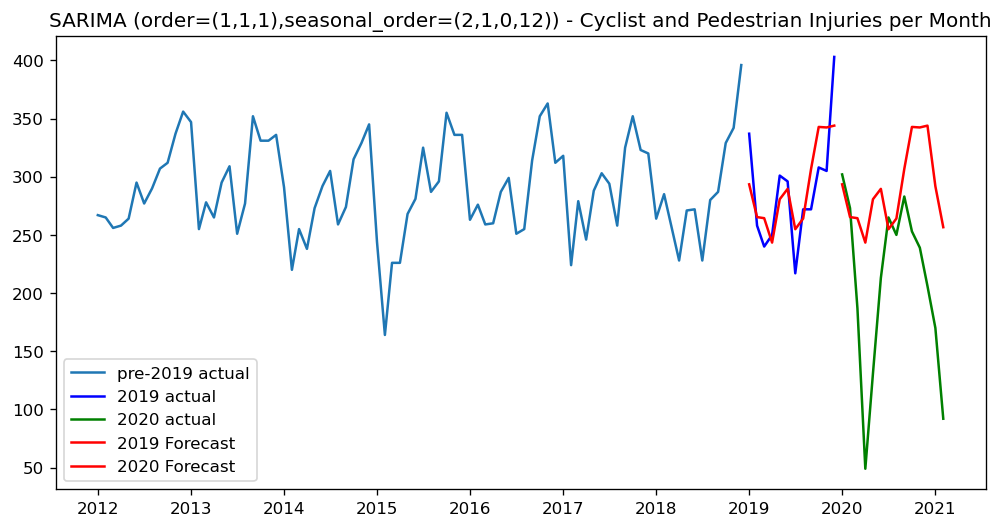

In [36]:
plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(pd.to_datetime(trainQn.Date), trainQn['Cyclist/Pedestrian Injuries'],label='pre-2019 actual')
plt.plot(pd.to_datetime(validQn.Date), validQn['Cyclist/Pedestrian Injuries'],color='blue',label='2019 actual')
plt.plot(pd.to_datetime(testQn.Date), testQn['Cyclist/Pedestrian Injuries'],color='green',label='2020 actual')
plt.plot(pd.to_datetime(validQn.Date), resultsQn.forecast(steps=len(validQn), alpha=0.05), label='2019 Forecast', color='red')
plt.plot(pd.to_datetime(testQn.Date), resultsQn.forecast(steps=len(testQn), alpha=0.05), label='2020 Forecast', color='red')
plt.title('SARIMA (order=(1,1,1),seasonal_order=(2,1,0,12)) - Cyclist and Pedestrian Injuries per Month')
plt.legend(loc='lower left')

In [40]:
print('2019 R2 Score:',r2_score(validQn['Cyclist/Pedestrian Injuries'], resultsQn.forecast(steps=len(validQn), alpha=0.05)))
print('2020 R2 Score:',r2_score(testQn['Cyclist/Pedestrian Injuries'], resultsQn.forecast(steps=len(testQn), alpha=0.05)))

2019 R2 Score: 0.557302986404975
2020 R2 Score: -1.0852169445955515


In [178]:
mean_absolute_percentage_error(validQn['Cyclist/Pedestrian Injuries'],resultsQn.forecast(steps=len(validQn)))

9.06808720365831

In [179]:
mean_absolute_percentage_error(testQn['Cyclist/Pedestrian Injuries'],resultsQn.forecast(steps=len(testQn)))

72.00973830587094

## Queens Model 2019 R^2 = 0.56
## 2020 R^2 = -1.09

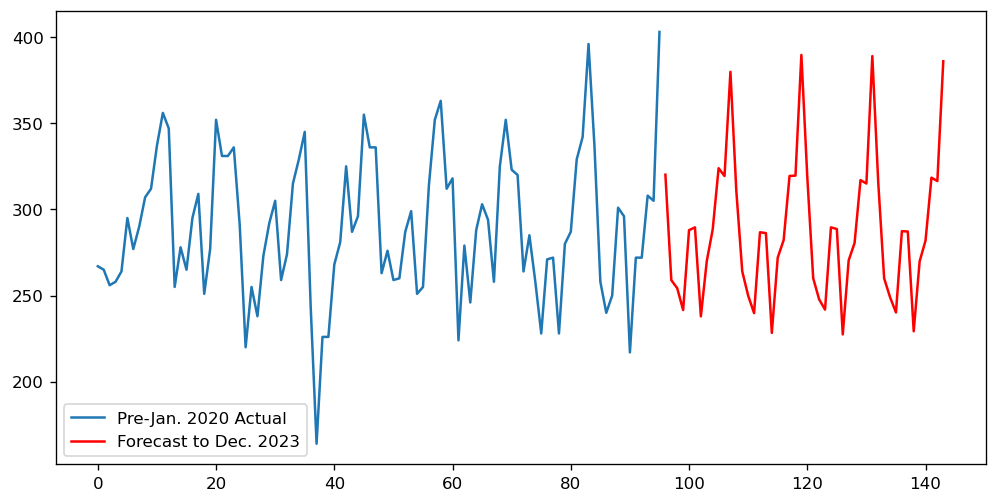

In [41]:
modelQn2 = SARIMAX(dfQueens['Cyclist/Pedestrian Injuries'][:96],order=(1,1,1),seasonal_order=(2,1,0,12))
resultsQn2 = modelQn2.fit()

plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(dfQueens.index[:96], dfQueens['Cyclist/Pedestrian Injuries'][:96],label='Pre-Jan. 2020 Actual')
plt.plot(x[96:], resultsQn2.forecast(steps=48, alpha=0.05), label='Forecast to Dec. 2023', color='red')
plt.legend(loc='lower left')

In [224]:
res=resultsQn2.forecast(24)
res[12:]

108    310.590391
109    263.996619
110    249.935362
111    239.817787
112    286.748794
113    286.245740
114    228.314512
115    272.033419
116    282.155204
117    319.426392
118    319.593319
119    389.656013
Name: predicted_mean, dtype: float64

In [225]:
res[12:].mean()

287.3761291759093

 _______________________________________________________________________________________________________________________

## Manhattan Model

In [46]:
f, PSD = scipy.signal.periodogram(dfMan['Cyclist/Pedestrian Injuries'][:96])
PSD = PSD[f>0.01]
f = f[f>0.01]
print('Strongest period = {}'.format(1/f[np.argmax(PSD)]))

Strongest period = 12.0


In [47]:
result = adfuller(dfMan['Cyclist/Pedestrian Injuries'])
print('p-value: %f' % result[1])
result = adfuller(dfMan['Cyclist/Pedestrian Injuries'].diff().diff(12).dropna().values)
print('p-value: %f' % result[1])

p-value: 0.996723
p-value: 0.000403


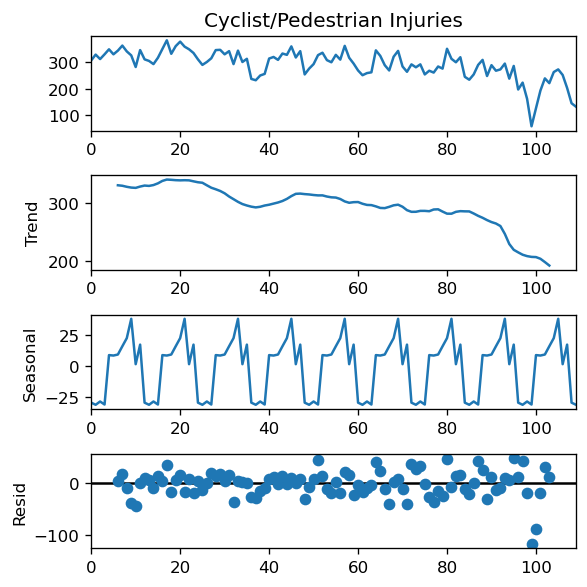

In [48]:
matplotlib.rcParams['figure.figsize'] = [5,5]
res = sm.tsa.seasonal_decompose(dfMan['Cyclist/Pedestrian Injuries'],model='additive',freq=12)
res.plot()
plt.show()

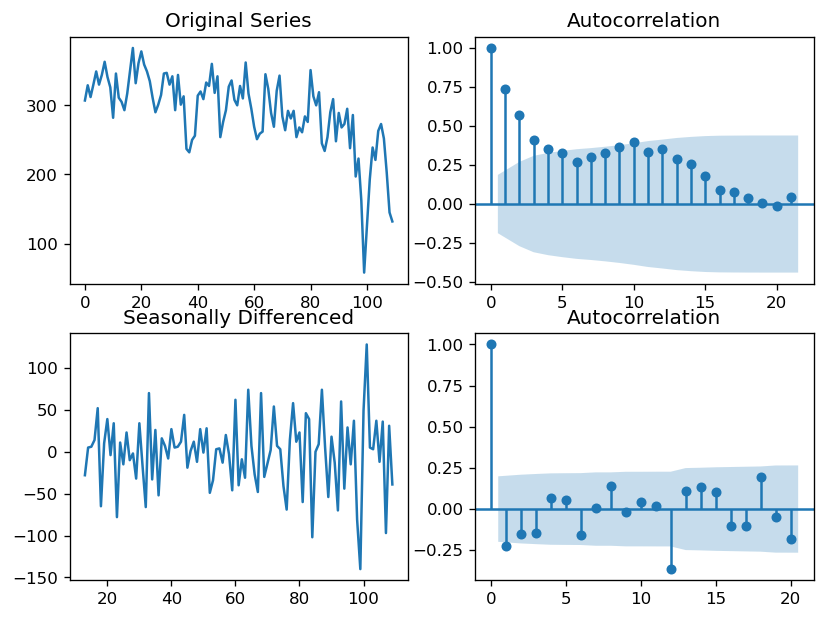

In [49]:
plt.rcParams.update({'figure.figsize':(8,6), 'figure.dpi':120})
fig, axes = plt.subplots(2, 2)

axes[0, 0].plot(dfMan['Cyclist/Pedestrian Injuries']); axes[0, 0].set_title('Original Series')
plot_acf(dfMan['Cyclist/Pedestrian Injuries'].dropna(), ax=axes[0, 1])

axes[1, 0].plot(dfMan['Cyclist/Pedestrian Injuries'].diff().diff(12)); axes[1, 0].set_title('Seasonally Differenced')
plot_acf(dfMan['Cyclist/Pedestrian Injuries'].diff().diff(12).dropna(), ax=axes[1, 1])
plt.show()

In [50]:
model = pm.auto_arima(dfMan['Cyclist/Pedestrian Injuries'], d=1, D=1,
                      m=12, trend='c', seasonal=True, 
                      start_p=0, start_q=0, max_order=6, test='adf',
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=980.011, Time=0.41 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1009.017, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=984.343, Time=0.45 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=971.355, Time=0.44 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1000.150, Time=0.16 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=971.752, Time=0.53 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=972.161, Time=0.86 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=975.105, Time=0.36 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=973.488, Time=1.10 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=978.262, Time=0.22 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=960.963, Time=0.56 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.42 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=962.461, Time=1.17 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=962.520, Time=2.71 sec
 ARIMA(1,1,1)(1,1,0)[12]           

In [51]:
trainMan=dfMan[['Date','Cyclist/Pedestrian Injuries']][:84]
validMan=dfMan[['Date','Cyclist/Pedestrian Injuries']][84:96]
testMan=dfMan[['Date','Cyclist/Pedestrian Injuries']][96:]
modelMan = SARIMAX(trainMan['Cyclist/Pedestrian Injuries'],order=(1,1,1),seasonal_order=(0,1,1,12))
resultsMan = modelMan.fit()
resultsMan.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:        Cyclist/Pedestrian Injuries   No. Observations:                   84
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -336.498
Date:                            Mon, 26 Apr 2021   AIC                            680.996
Time:                                    11:00:43   BIC                            690.047
Sample:                                         0   HQIC                           684.595
                                             - 84                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3523      0.130      2.720      0.007       0.098       0.606
ma.L1         -0.9997     18.452     -0.054      0.957     -37.166      35.166
ma.S.L12      -0.7468      0.186     -4.024      0.000      -1.111      -0.383
sigma2       623.5001   1.15e+04      0.054      0.957   -2.19e+04    2.31e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 0.91
Prob(Q):                              0.84   Prob(JB):                         0.63
Heteroskedasticity (H):               1.47   Skew:                             0.09
Prob(H) (two-sided):                  0.36   Kurtosis:                         2.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

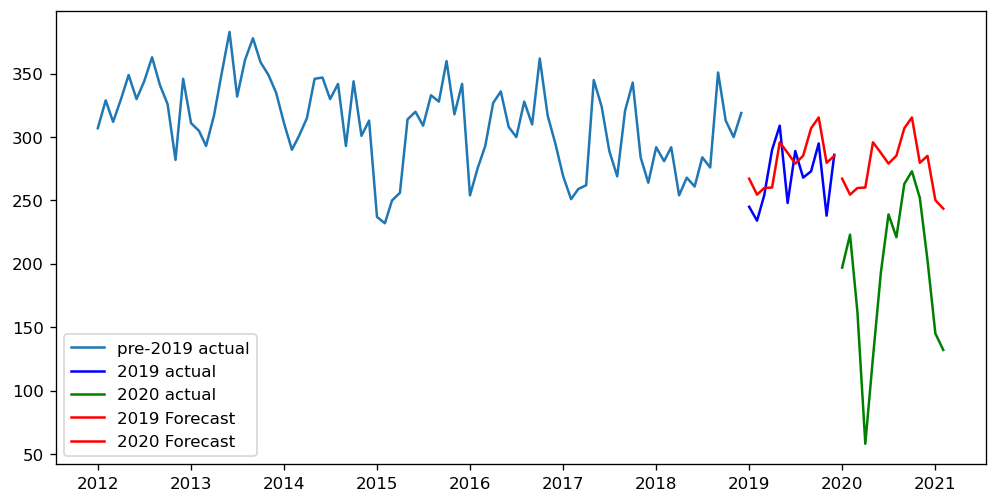

In [52]:
plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(pd.to_datetime(trainMan.Date), trainMan['Cyclist/Pedestrian Injuries'],label='pre-2019 actual')
plt.plot(pd.to_datetime(validMan.Date), validMan['Cyclist/Pedestrian Injuries'],color='blue',label='2019 actual')
plt.plot(pd.to_datetime(testMan.Date), testMan['Cyclist/Pedestrian Injuries'],color='green',label='2020 actual')
plt.plot(pd.to_datetime(validMan.Date), resultsMan.forecast(steps=len(validMan), alpha=0.05), label='2019 Forecast', color='red')
plt.plot(pd.to_datetime(testMan.Date), resultsMan.forecast(steps=len(testMan), alpha=0.05), label='2020 Forecast', color='red')
plt.legend(loc='lower left')

In [301]:
r2_score(validMan['Cyclist/Pedestrian Injuries'], resultsMan.forecast(steps=len(validMan), alpha=0.05))

-0.06361402348598322

In [302]:
r2_score(testMan['Cyclist/Pedestrian Injuries'], resultsMan.forecast(steps=len(testMan), alpha=0.05))

-1.7841048636606458

In [300]:
mean_absolute_percentage_error(validMan['Cyclist/Pedestrian Injuries'],resultsMan.forecast(steps=len(validMan)))

8.141035511904558

In [181]:
mean_absolute_percentage_error(testMan['Cyclist/Pedestrian Injuries'],resultsMan.forecast(steps=len(testMan)))

66.38064267263579

## Manhattan Model 2019 R^2 Score = -0.06

## 2020 R^2 Score = -1.78

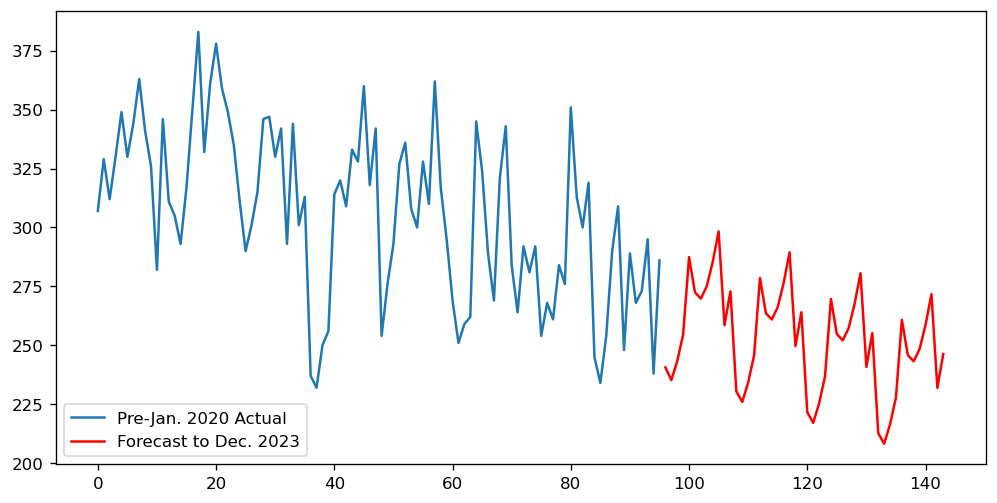

In [295]:
modelMan2 = SARIMAX(dfMan['Cyclist/Pedestrian Injuries'][:96],order=(1,1,1),seasonal_order=(0,1,1,12))
resultsMan2 = modelMan2.fit()

plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(dfMan.index[:96], dfMan['Cyclist/Pedestrian Injuries'][:96],label='Pre-Jan. 2020 Actual')
plt.plot(x[96:], resultsMan2.forecast(steps=48, alpha=0.05), label='Forecast to Dec. 2023', color='red')
plt.legend(loc='lower left')

In [296]:
res=resultsMan2.forecast(24)
res[12:].mean()

257.08922861737966

In [297]:
res=resultsMan2.forecast(36)
res[24:].mean()

248.21690370564372

In [298]:
res=resultsMan2.forecast(48)
res[36:].mean()

239.34457889700113

In [299]:
res=resultsMan2.forecast(60)
res[48:].mean()

230.47225408835865

 _______________________________________________________________________________________________________________________

## Brooklyn Model

In [55]:
f, PSD = scipy.signal.periodogram(dfBk['Cyclist/Pedestrian Injuries'])
PSD = PSD[f>0.01]
f = f[f>0.01]
print('Strongest period = {}'.format(1/f[np.argmax(PSD)]))

Strongest period = 12.222222222222221


In [56]:
result = adfuller(dfBk['Cyclist/Pedestrian Injuries'])
print('p-value: %f' % result[1])
result = adfuller(dfBk['Cyclist/Pedestrian Injuries'].diff().diff(12).dropna().values)
print('p-value: %f' % result[1])

p-value: 0.994741
p-value: 0.002997


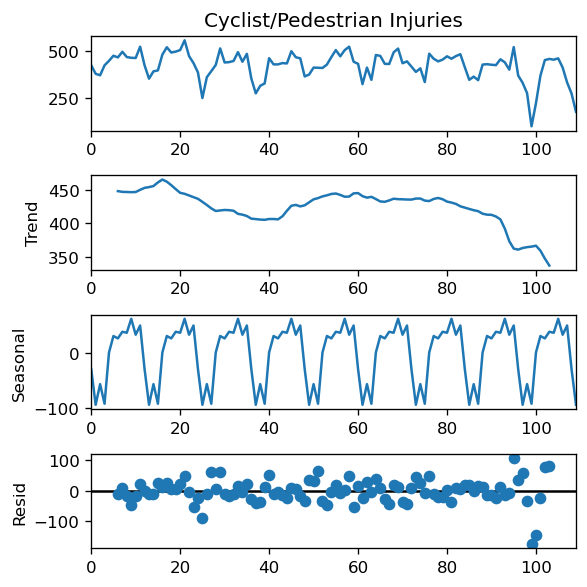

In [57]:
matplotlib.rcParams['figure.figsize'] = [5,5]
res = sm.tsa.seasonal_decompose(dfBk['Cyclist/Pedestrian Injuries'],model='additive',freq=12)
res.plot()
plt.show()

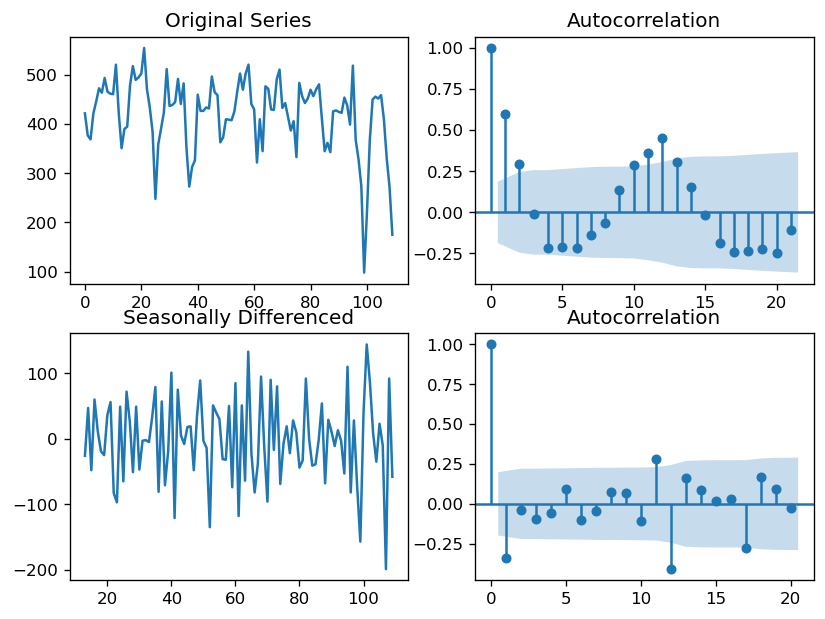

In [58]:
plt.rcParams.update({'figure.figsize':(8,6), 'figure.dpi':120})
fig, axes = plt.subplots(2, 2)

axes[0, 0].plot(dfBk['Cyclist/Pedestrian Injuries']); axes[0, 0].set_title('Original Series')
plot_acf(dfBk['Cyclist/Pedestrian Injuries'].dropna(), ax=axes[0, 1])

axes[1, 0].plot(dfBk['Cyclist/Pedestrian Injuries'].diff().diff(12)); axes[1, 0].set_title('Seasonally Differenced')
plot_acf(dfBk['Cyclist/Pedestrian Injuries'].diff().diff(12).dropna(), ax=axes[1, 1])
plt.show()

In [59]:
model = pm.auto_arima(dfBk['Cyclist/Pedestrian Injuries'], d=1, D=1,
                      m=12, trend='c', seasonal=True, 
                      start_p=0, start_q=0, max_order=6, test='adf',
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1055.987, Time=0.85 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1087.169, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1059.517, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1048.932, Time=0.27 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1065.386, Time=0.11 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1050.669, Time=0.60 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1050.677, Time=0.59 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1055.406, Time=0.49 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1052.440, Time=1.50 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1055.006, Time=0.25 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1036.360, Time=1.05 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1059.311, Time=0.45 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.84 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=inf, Time=1.22 sec
 ARIMA(1,1,1)(1,1,0)[12]     

In [60]:
trainBk=dfBk[['Date','Cyclist/Pedestrian Injuries']][:84]
validBk=dfBk[['Date','Cyclist/Pedestrian Injuries']][84:96]
testBk=dfBk[['Date','Cyclist/Pedestrian Injuries']][96:]

In [61]:
modelBk = SARIMAX(trainBk['Cyclist/Pedestrian Injuries'],order=(1,1,1),seasonal_order=(0,1,1,12))
resultsBk = modelBk.fit()
resultsBk.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:        Cyclist/Pedestrian Injuries   No. Observations:                   84
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -362.051
Date:                            Mon, 26 Apr 2021   AIC                            732.101
Time:                                    11:01:57   BIC                            741.152
Sample:                                         0   HQIC                           735.700
                                             - 84                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0928      0.148      0.626      0.532      -0.198       0.383
ma.L1         -0.8487      0.085    -10.041      0.000      -1.014      -0.683
ma.S.L12      -0.8997      0.530     -1.697      0.090      -1.939       0.140
sigma2      1220.5874    619.067      1.972      0.049       7.239    2433.936
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.26
Prob(Q):                              0.97   Prob(JB):                         0.88
Heteroskedasticity (H):               0.98   Skew:                            -0.14
Prob(H) (two-sided):                  0.96   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

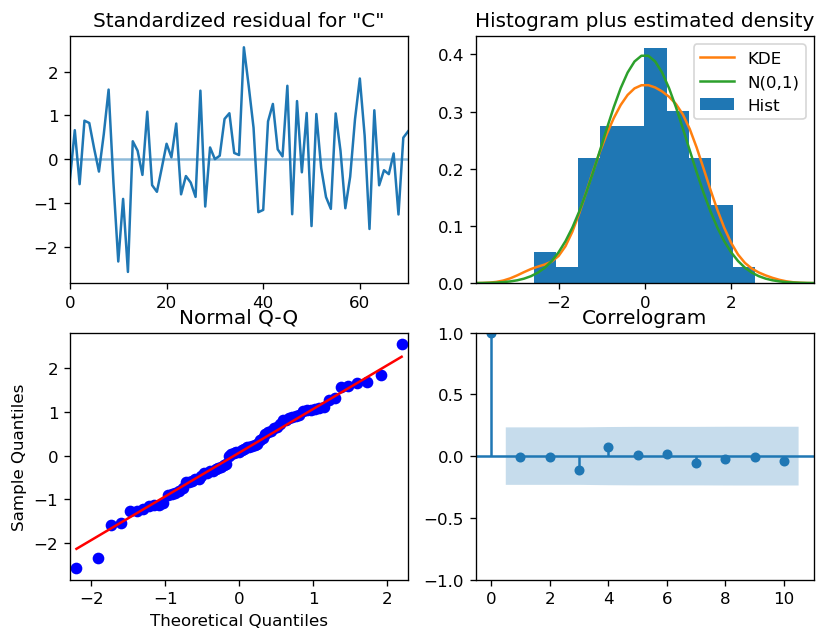

In [62]:
resultsBk.plot_diagnostics()
plt.show()

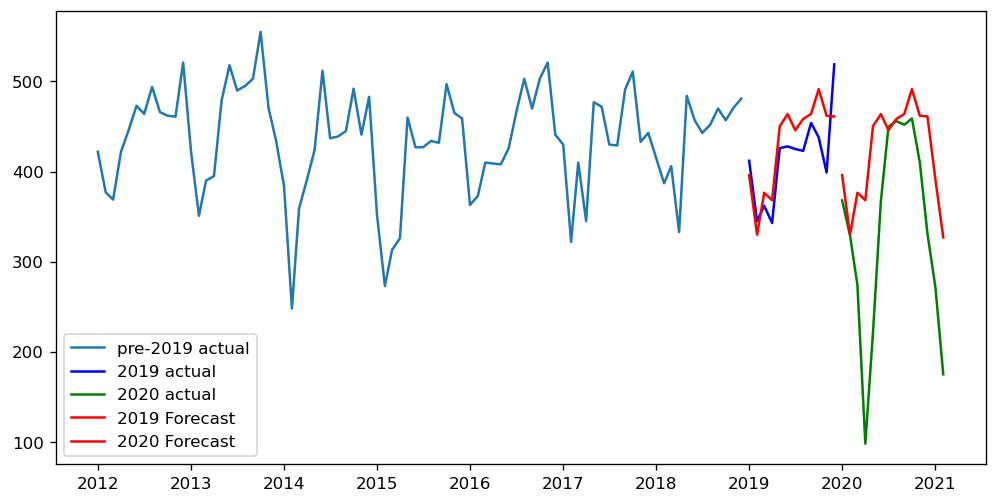

In [63]:
plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(pd.to_datetime(trainBk.Date), trainBk['Cyclist/Pedestrian Injuries'],label='pre-2019 actual')
plt.plot(pd.to_datetime(validBk.Date), validBk['Cyclist/Pedestrian Injuries'],color='blue',label='2019 actual')
plt.plot(pd.to_datetime(testBk.Date), testBk['Cyclist/Pedestrian Injuries'],color='green',label='2020 actual')
plt.plot(pd.to_datetime(validBk.Date), resultsBk.forecast(steps=len(validBk), alpha=0.05), label='2019 Forecast', color='red')
plt.plot(pd.to_datetime(testBk.Date), resultsBk.forecast(steps=len(testBk), alpha=0.05), label='2020 Forecast', color='red')
plt.legend(loc='lower left')

In [64]:
r2_score(validBk['Cyclist/Pedestrian Injuries'], resultsBk.forecast(steps=len(validBk), alpha=0.05))

0.4274238311094769

In [65]:
r2_score(testBk['Cyclist/Pedestrian Injuries'], resultsBk.forecast(steps=len(testBk), alpha=0.05))

-0.22396271925314193

In [182]:
mean_absolute_percentage_error(validBk['Cyclist/Pedestrian Injuries'],resultsBk.forecast(steps=len(validBk)))

7.358297652310855

In [184]:
mean_absolute_percentage_error(testBk['Cyclist/Pedestrian Injuries'],resultsBk.forecast(steps=len(testBk)))

46.08582060894849

## Brooklyn Model 2019 R^2 Score = 0.43

## 2020 R^2 Score = -0.22

In [67]:
x = np.arange(144)

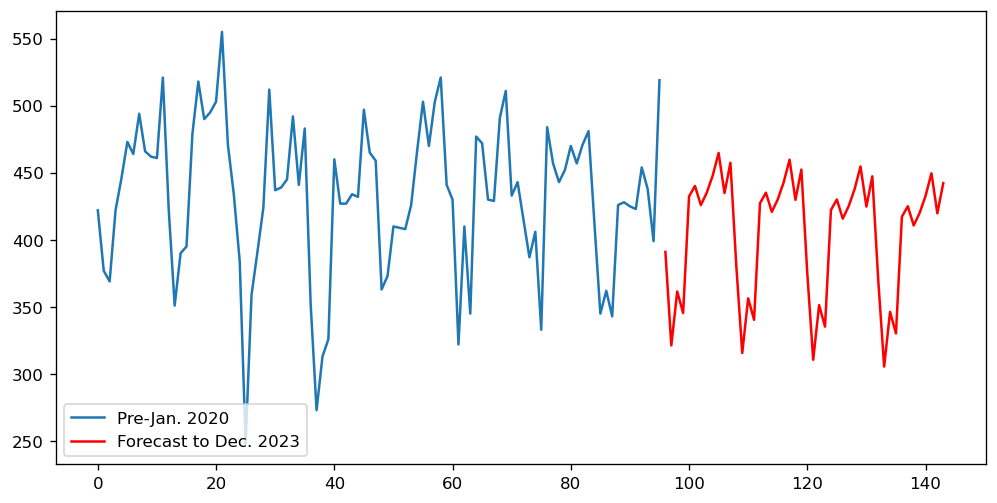

In [68]:
modelBk2 = SARIMAX(dfBk['Cyclist/Pedestrian Injuries'][:96],order=(1,1,1),seasonal_order=(0,1,1,12))
resultsBk2 = modelBk2.fit()

plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(dfBk.index[:96], dfBk['Cyclist/Pedestrian Injuries'][:96],label='Pre-Jan. 2020')
plt.plot(x[96:], resultsBk2.forecast(steps=48, alpha=0.05), label='Forecast to Dec. 2023', color='red')
plt.legend(loc='lower left')

In [232]:
res=resultsBk2.forecast(60)
res[48:]

144    365.001531
145    300.497384
146    341.243747
147    325.229828
148    412.140493
149    420.004039
150    405.691075
151    414.998722
152    427.673287
153    444.595909
154    414.700009
155    437.251643
Name: predicted_mean, dtype: float64

In [233]:
res[48:].mean()

392.41897223548057

 _______________________________________________________________________________________________________________________

## Citywide Model

In [279]:
df_monthly=dfMan[['Date','Injury_or_fatal_collisions','PedestriansInjured']].copy()
df_monthly['Injury_or_fatal_collisions']=dfMan['Injury_or_fatal_collisions']+dfBk['Injury_or_fatal_collisions']+dfBronx['Injury_or_fatal_collisions']+dfQueens['Injury_or_fatal_collisions']+dfStat['Injury_or_fatal_collisions']
df_monthly['PedestriansInjured']=dfMan['PedestriansInjured']+dfBk['PedestriansInjured']+dfBronx['PedestriansInjured']+dfQueens['PedestriansInjured']+dfStat['PedestriansInjured']
df_monthly['PedestriansKilled']=dfMan['PedestriansKilled']+dfBk['PedestriansKilled']+dfBronx['PedestriansKilled']+dfQueens['PedestriansKilled']+dfStat['PedestriansKilled']
df_monthly['CyclistsInjured']=dfMan['CyclistsInjured']+dfBk['CyclistsInjured']+dfBronx['CyclistsInjured']+dfQueens['CyclistsInjured']+dfStat['CyclistsInjured']
df_monthly['CyclistsKilled']=dfMan['CyclistsKilled']+dfBk['CyclistsKilled']+dfBronx['CyclistsKilled']+dfQueens['CyclistsKilled']+dfStat['CyclistsKilled']
df_monthly['Cyclist/Pedestrian Injuries']=df_monthly['CyclistsInjured']+df_monthly['PedestriansInjured']
df_monthly['Cyclist/Pedestrian Fatalities']=df_monthly['CyclistsKilled']+df_monthly['PedestriansKilled']
df_monthly.head(2)

,Date,Injury_or_fatal_collisions,PedestriansInjured,PedestriansKilled,CyclistsInjured,CyclistsKilled,Cyclist/Pedestrian Injuries,Cyclist/Pedestrian Fatalities
0,1-2012,3075,1045,12,172,1,1217,13
1,2-2012,2823,998,9,177,1,1175,10


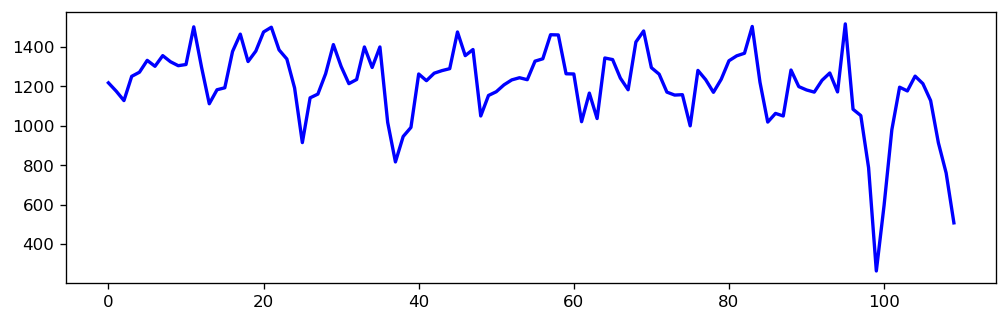

In [70]:
fig, ax = plt.subplots(figsize=(10, 3))
plt.plot(df_monthly.index,'Cyclist/Pedestrian Injuries', data=df_monthly, marker='', color='blue', linewidth=2)
plt.show()

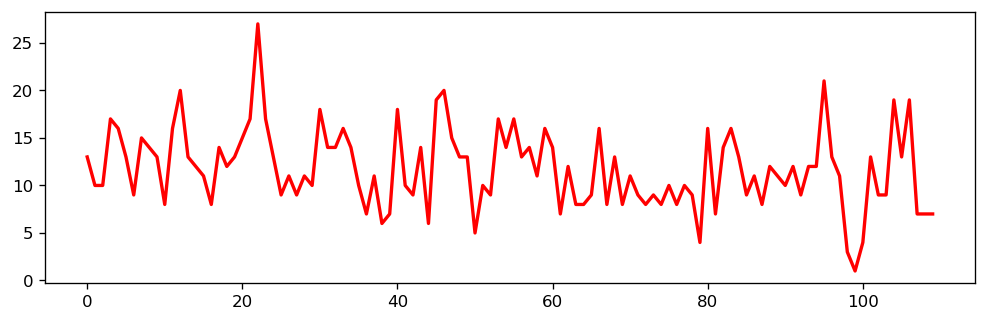

In [71]:
fig, ax = plt.subplots(figsize=(10, 3))
plt.plot(df_monthly.index,'Cyclist/Pedestrian Fatalities', data=df_monthly, marker='', color='red', linewidth=2)
plt.show()

In [72]:
f, PSD = scipy.signal.periodogram(df_monthly['Cyclist/Pedestrian Injuries'])
PSD = PSD[f>0.01]
f = f[f>0.01]
print('Strongest period = {}'.format(1/f[np.argmax(PSD)]))

Strongest period = 12.222222222222221


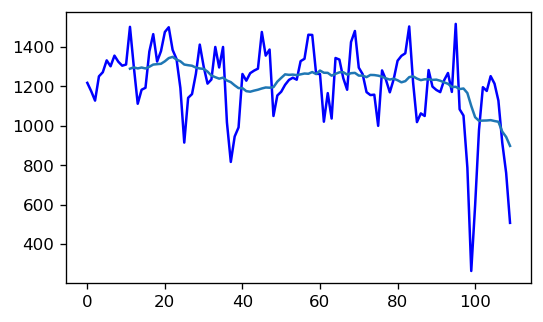

In [73]:
df_monthly['Cyclist/Pedestrian Injuries'].plot(color='blue', figsize=(5, 3))
plt.plot(df_monthly['Cyclist/Pedestrian Injuries'].rolling(window = 12).mean())

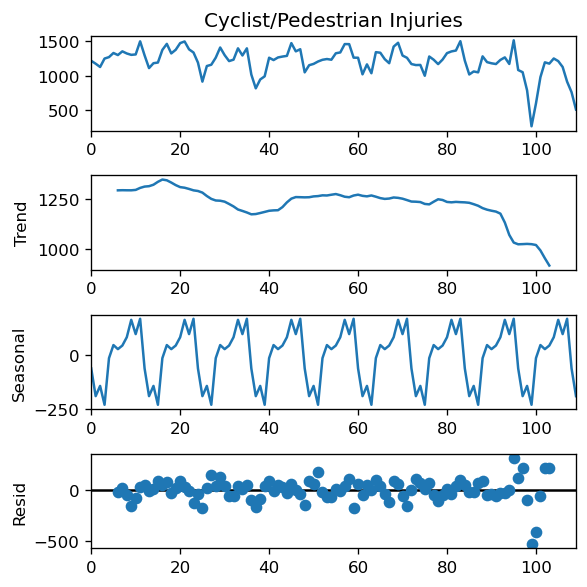

In [74]:
matplotlib.rcParams['figure.figsize'] = [5,5]
res = sm.tsa.seasonal_decompose(df_monthly['Cyclist/Pedestrian Injuries'],model='additive',freq=12)
res.plot()
plt.show()

In [76]:
series = df_monthly['Cyclist/Pedestrian Injuries'].diff().diff(12)
result = adfuller(series.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.769908
p-value: 0.003231


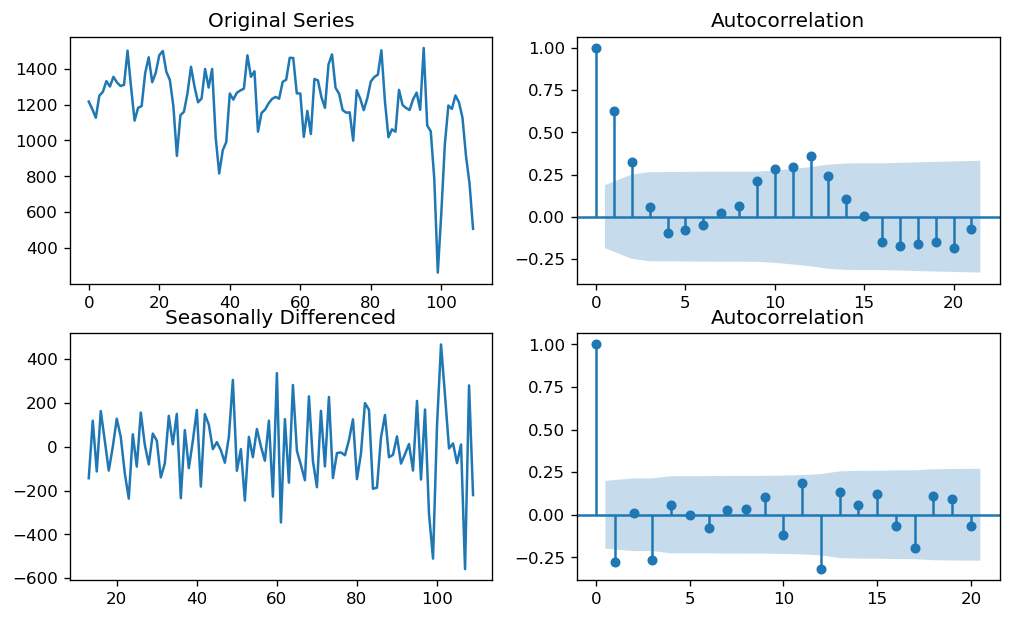

In [77]:
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':120})
# Original Series
fig, axes = plt.subplots(2, 2)
axes[0, 0].plot(df_monthly['Cyclist/Pedestrian Injuries']); axes[0, 0].set_title('Original Series')
plot_acf(df_monthly['Cyclist/Pedestrian Injuries'].dropna(), ax=axes[0, 1])
# 1st Differencing
axes[1, 0].plot(df_monthly['Cyclist/Pedestrian Injuries'].diff().diff(12)); axes[1, 0].set_title('Seasonally Differenced')
plot_acf(df_monthly['Cyclist/Pedestrian Injuries'].diff().diff(12).dropna(), ax=axes[1, 1])
plt.show()

In [78]:
import pmdarima as pm
model = pm.auto_arima(df_monthly['Cyclist/Pedestrian Injuries'], d=1, D=1,
                      m=12, trend='c', seasonal=True, 
                      start_p=0, start_q=0, max_order=6, test='adf',
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1247.526, Time=0.81 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1271.988, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1253.919, Time=0.28 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1243.827, Time=0.69 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1262.087, Time=0.20 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1245.747, Time=0.54 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1245.743, Time=1.30 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1251.527, Time=0.40 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1247.351, Time=1.39 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1245.707, Time=0.50 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1230.874, Time=0.60 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1251.972, Time=0.40 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=1.17 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1232.869, Time=1.60 sec
 ARIMA(1,1,1)(1,1,0)[12]

In [185]:
train=df_monthly[['Date','Cyclist/Pedestrian Injuries']][:84]
valid=df_monthly[['Date','Cyclist/Pedestrian Injuries']][84:96]
test=df_monthly[['Date','Cyclist/Pedestrian Injuries']][96:]

In [186]:
model = SARIMAX(train['Cyclist/Pedestrian Injuries'],order=(1,1,1),seasonal_order=(0,1,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:        Cyclist/Pedestrian Injuries   No. Observations:                   84
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -427.752
Date:                            Mon, 26 Apr 2021   AIC                            863.504
Time:                                    16:21:53   BIC                            872.555
Sample:                                         0   HQIC                           867.103
                                             - 84                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1795      0.158      1.133      0.257      -0.131       0.490
ma.L1         -0.8564      0.101     -8.488      0.000      -1.054      -0.659
ma.S.L12      -0.9970     17.409     -0.057      0.954     -35.118      33.124
sigma2      7121.2075   1.24e+05      0.057      0.954   -2.36e+05     2.5e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.59
Prob(Q):                              1.00   Prob(JB):                         0.74
Heteroskedasticity (H):               1.12   Skew:                            -0.02
Prob(H) (two-sided):                  0.78   Kurtosis:                         2.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

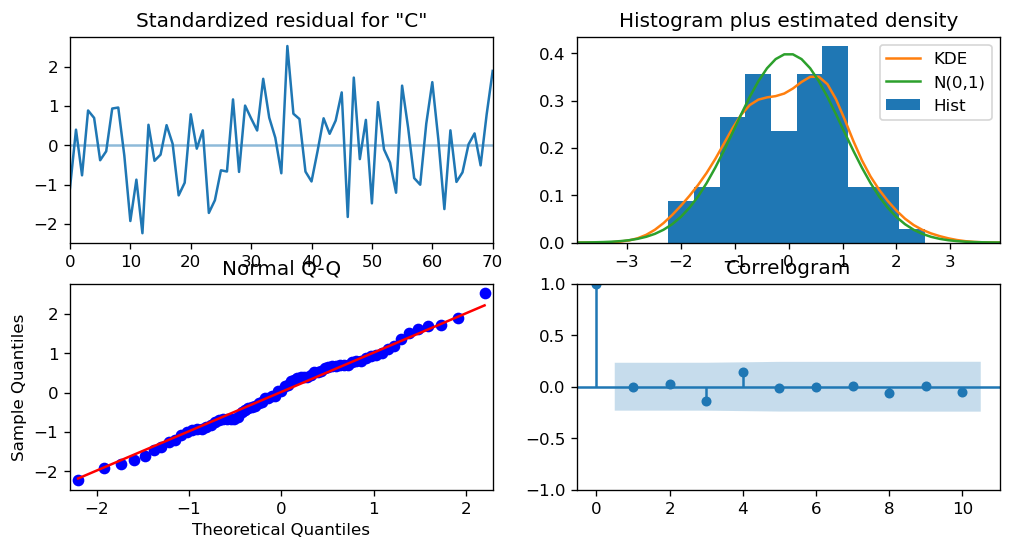

In [187]:
results.plot_diagnostics()
plt.show()

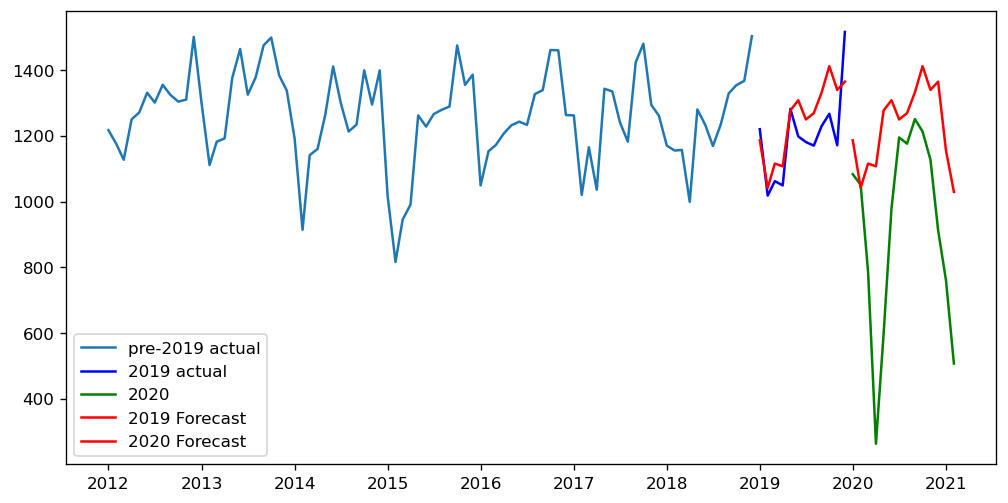

In [188]:
plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(pd.to_datetime(train.Date), train['Cyclist/Pedestrian Injuries'],label='pre-2019 actual')
plt.plot(pd.to_datetime(valid.Date), valid['Cyclist/Pedestrian Injuries'],color='blue',label='2019 actual')
plt.plot(pd.to_datetime(test.Date), test['Cyclist/Pedestrian Injuries'],color='green',label='2020')
plt.plot(pd.to_datetime(valid.Date), results.forecast(steps=len(valid), alpha=0.05), label='2019 Forecast', color='red')
plt.plot(pd.to_datetime(test.Date), results.forecast(steps=len(test), alpha=0.05), label='2020 Forecast', color='red')
plt.legend(loc='lower left')

In [156]:
r2_score(valid['Cyclist/Pedestrian Injuries'], results.forecast(steps=len(valid), alpha=0.05))

0.3805440272780066

In [157]:
r2_score(test['Cyclist/Pedestrian Injuries'], results.forecast(steps=len(test), alpha=0.05))

-0.816680682441923

In [189]:
mean_absolute_percentage_error(valid['Cyclist/Pedestrian Injuries'],results.forecast(steps=len(valid)))

6.968474428797437

In [190]:
mean_absolute_percentage_error(test['Cyclist/Pedestrian Injuries'],results.forecast(steps=len(test)))

55.68406212358069

## Citywide Model R^2 Score: 0.38

## 2020 R^2 Score = -0.82

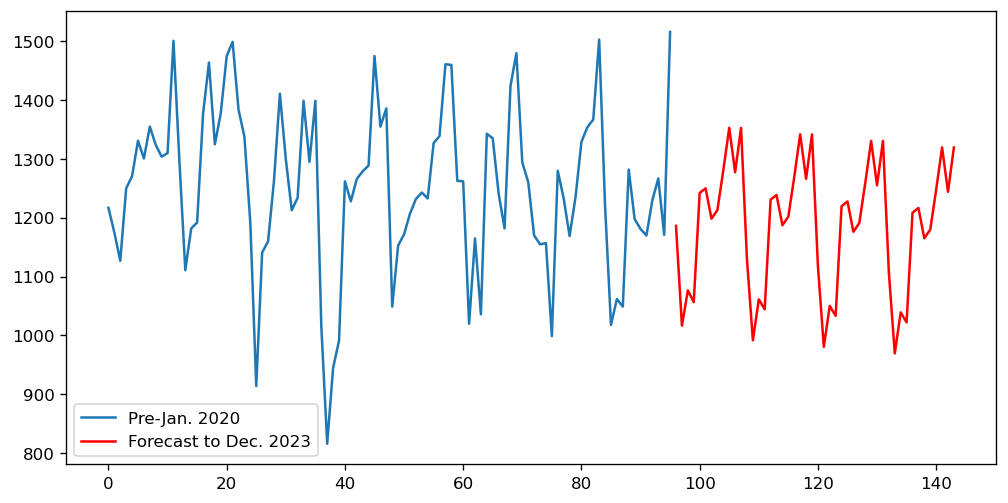

In [234]:
model2 = SARIMAX(df_monthly['Cyclist/Pedestrian Injuries'][:96],order=(1,1,1),seasonal_order=(0,1,1,12))
results2 = model2.fit()

plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(df_monthly.index[:96], df_monthly['Cyclist/Pedestrian Injuries'][:96],label='Pre-Jan. 2020')
plt.plot(x[96:], results2.forecast(steps=48, alpha=0.05), label='Forecast to Dec. 2023', color='red')
plt.legend(loc='lower left')

In [238]:
res=results2.forecast(24)
res[12:].mean()

1192.1630706187127

___________________________________________________________________________________________________________

## Citywide Fatality Model

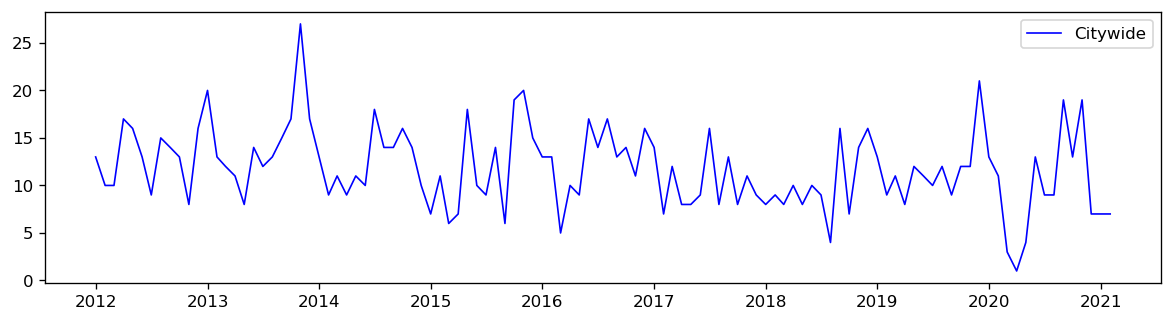

In [103]:
fig, ax = plt.subplots(figsize=(12, 3))
plt.plot(pd.to_datetime(df_monthly.Date),'Cyclist/Pedestrian Fatalities', data=df_monthly, marker='', color='blue', linewidth=1, label="Citywide")
plt.legend()
plt.show()

In [108]:
f, PSD = scipy.signal.periodogram(df_monthly['Cyclist/Pedestrian Fatalities'])
PSD = PSD[f>0.01]
f = f[f>0.01]
print('Strongest period = {}'.format(1/f[np.argmax(PSD)]))

Strongest period = 12.222222222222221


In [109]:
res = adfuller(df_monthly['Cyclist/Pedestrian Fatalities'])
print('ADF Statistic: %f'%res[0])
print('p-value: %f'%res[1])

ADF Statistic: -5.509130
p-value: 0.000002


In [110]:
series = df_monthly['Cyclist/Pedestrian Fatalities'].diff().diff(12)
result = adfuller(series.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.217221
p-value: 0.019009


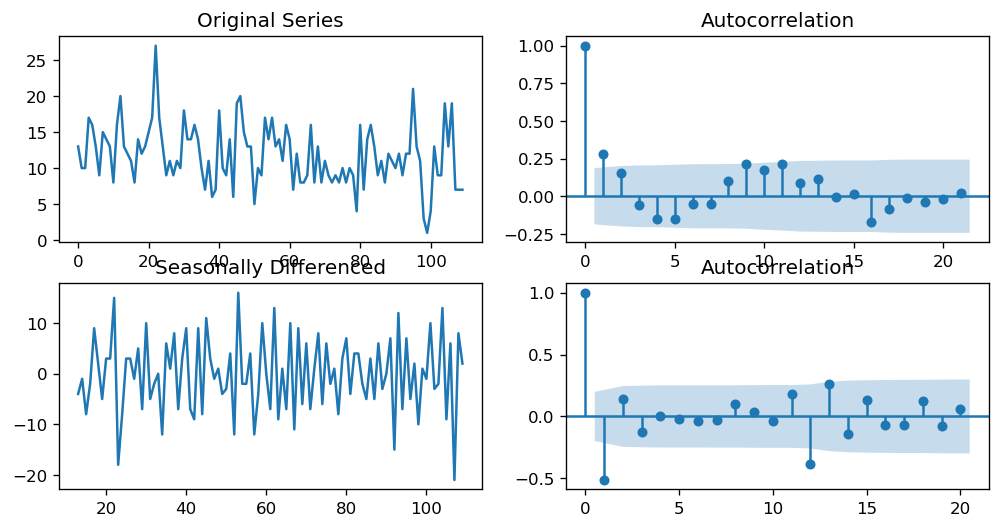

In [111]:
fig, axes = plt.subplots(2, 2)
axes[0, 0].plot(df_monthly['Cyclist/Pedestrian Fatalities']); axes[0, 0].set_title('Original Series')
plot_acf(df_monthly['Cyclist/Pedestrian Fatalities'].dropna(), ax=axes[0, 1])

axes[1, 0].plot(df_monthly['Cyclist/Pedestrian Fatalities'].diff().diff(12)); axes[1, 0].set_title('Seasonally Differenced')
plot_acf(df_monthly['Cyclist/Pedestrian Fatalities'].diff().diff(12).dropna(), ax=axes[1, 1])
plt.show()

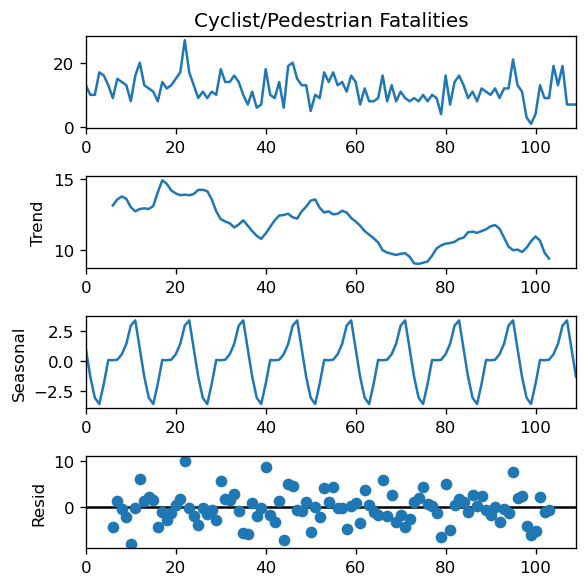

In [114]:
matplotlib.rcParams['figure.figsize'] = [5,5]
res = sm.tsa.seasonal_decompose(df_monthly['Cyclist/Pedestrian Fatalities'],model='additive',freq=12)
res.plot()
plt.show()

In [195]:
import pmdarima as pm
model = pm.auto_arima(df_monthly['Cyclist/Pedestrian Fatalities'], d=1, D=1,
                      m=12, trend='c', seasonal=True, 
                      start_p=0, start_q=0, max_order=6, test='adf',
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.73 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=667.525, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=622.459, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.74 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=639.973, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=613.542, Time=0.67 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.03 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.92 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=637.985, Time=0.47 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=609.176, Time=0.83 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=620.466, Time=0.36 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=2.81 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.03 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=609.370, Time=0.88 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=inf, Time=2.79

In [192]:
train=df_monthly[['Date','Cyclist/Pedestrian Fatalities']][:84]
valid=df_monthly[['Date','Cyclist/Pedestrian Fatalities']][84:96]
test=df_monthly[['Date','Cyclist/Pedestrian Fatalities']][96:]

In [193]:
model = SARIMAX(train['Cyclist/Pedestrian Fatalities'],order=(2,1,0),seasonal_order=(2,1,0,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:      Cyclist/Pedestrian Fatalities   No. Observations:                   84
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -219.477
Date:                            Mon, 26 Apr 2021   AIC                            448.955
Time:                                    16:24:27   BIC                            460.268
Sample:                                         0   HQIC                           453.454
                                             - 84                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6571      0.122     -5.367      0.000      -0.897      -0.417
ar.L2         -0.3310      0.132     -2.513      0.012      -0.589      -0.073
ar.S.L12      -0.6931      0.150     -4.629      0.000      -0.987      -0.400
ar.S.L24      -0.4016      0.121     -3.319      0.001      -0.639      -0.164
sigma2        25.2940      4.591      5.509      0.000      16.296      34.292
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 1.81
Prob(Q):                              0.70   Prob(JB):                         0.40
Heteroskedasticity (H):               0.61   Skew:                             0.39
Prob(H) (two-sided):                  0.23   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

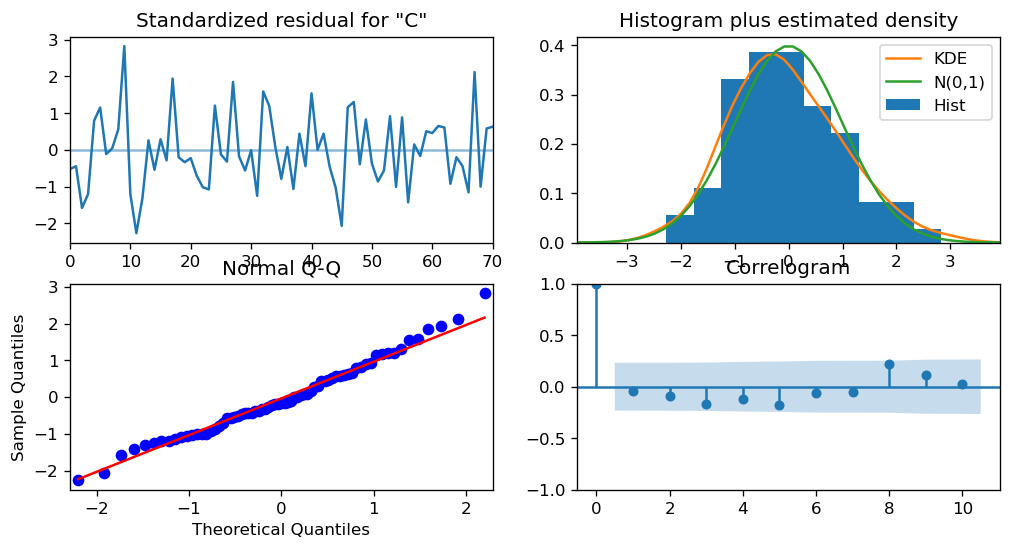

In [194]:
results.plot_diagnostics()
plt.show()

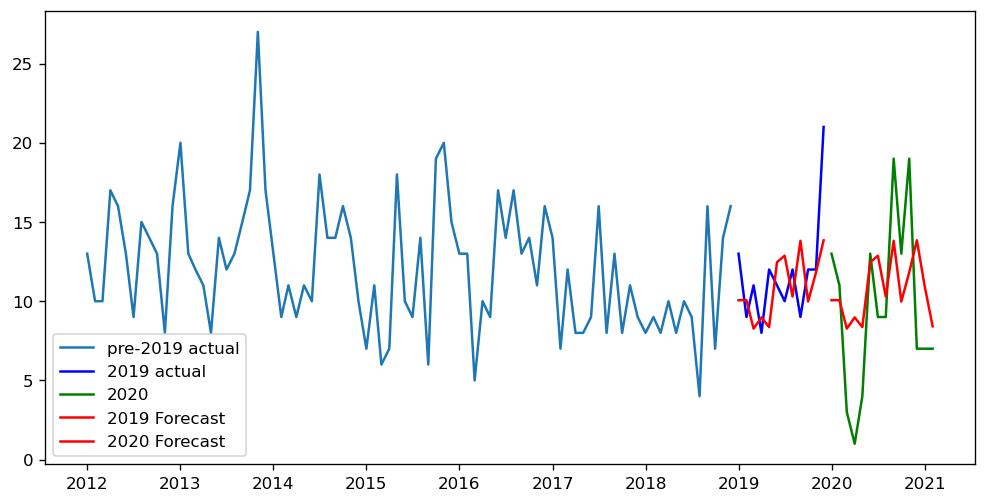

In [196]:
plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(pd.to_datetime(train.Date), train['Cyclist/Pedestrian Fatalities'],label='pre-2019 actual')
plt.plot(pd.to_datetime(valid.Date), valid['Cyclist/Pedestrian Fatalities'],color='blue',label='2019 actual')
plt.plot(pd.to_datetime(test.Date), test['Cyclist/Pedestrian Fatalities'],color='green',label='2020')
plt.plot(pd.to_datetime(valid.Date), results.forecast(steps=len(valid), alpha=0.05), label='2019 Forecast', color='red')
plt.plot(pd.to_datetime(test.Date), results.forecast(steps=len(test), alpha=0.05), label='2020 Forecast', color='red')
plt.legend(loc='lower left')

In [197]:
r2_score(valid['Cyclist/Pedestrian Fatalities'], results.forecast(steps=len(valid), alpha=0.05))

-0.020939829435095092

In [200]:
mean_absolute_percentage_error(valid['Cyclist/Pedestrian Fatalities'],results.forecast(steps=len(valid)))

22.000761852899863

In [198]:
r2_score(test['Cyclist/Pedestrian Fatalities'], results.forecast(steps=len(test), alpha=0.05))

0.24628937186059696

In [201]:
mean_absolute_percentage_error(test['Cyclist/Pedestrian Fatalities'],results.forecast(steps=len(test)))

102.65971290487977

## Citywide Fatality Model 2019 R^2 = -0.02

## 2020 Model R^2 = 0.25

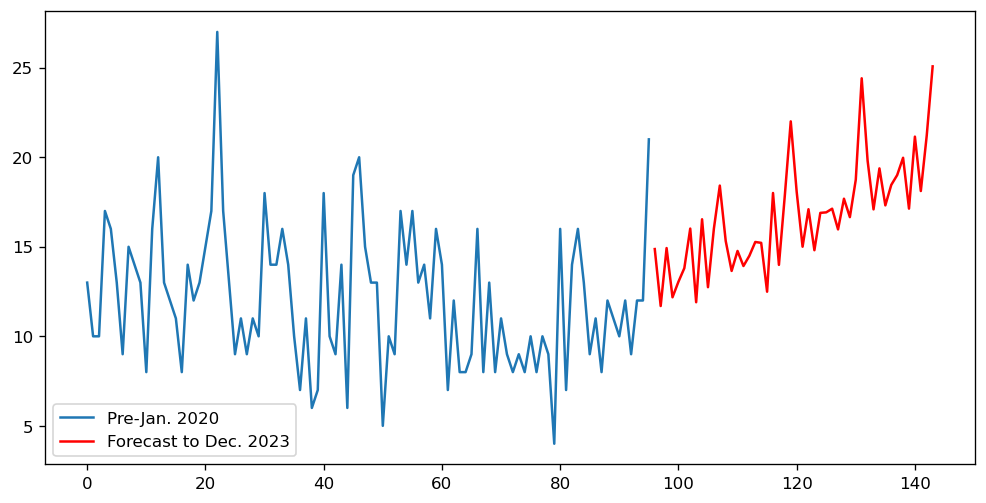

In [239]:
model2 = SARIMAX(df_monthly['Cyclist/Pedestrian Fatalities'][:96],order=(2,1,0),seasonal_order=(2,1,0,12))
results2 = model2.fit()

plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(df_monthly.index[:96], df_monthly['Cyclist/Pedestrian Fatalities'][:96],label='Pre-Jan. 2020')
plt.plot(x[96:], results2.forecast(steps=48, alpha=0.05), label='Forecast to Dec. 2023', color='red')
plt.legend(loc='lower left')

In [243]:
res=results2.forecast(60)
res[48:].mean()

21.126528993354167